In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import data
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [67]:
def visualize_results(X, Y_, Y, func, special=[]):
    # graph the decision surface
    bbox = (np.min(X, axis=0), np.max(X, axis=0))
    xmin, ymin = bbox[0]
    xmax, ymax = bbox[1]
    
    plt.figure(figsize=(10, 10))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    if False:
        possible_labels = np.array(range(C))
        mat = get_confusion_matrix(Y, Y_, possible_labels, True)
        accuracy, prec, rec = eval_perf_multi(mat)
        AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
        AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

        print()
        print("Accuracy")
        print(accuracy)
        print("Precision")
        print(prec)
        print("Recall")
        print(rec)
        for c in possible_labels:
            print("AP_c%d = %f" % (c, eval_AP(expected_output[probs[:,c].argsort()],c)))

    data.graph_surface(func, bbox)
    data.graph_data(X, Y_, Y, special=special)
    plt.show()

### 1. Generiranje linearno nerazdvojivih podataka

In [23]:
# todo: graph_surface & graph_data

In [2]:
X, Y_ = data.sample_gmm(4, 2, 30)

print(X.shape)
print(Y_.shape)

(120, 2)
(120,)


### 2. Višeslojna klasifikacija u Pythonu

In [3]:
# todo:

### 3. Linearna regresija u Tensorflowu

In [22]:
# todo: ispisati grads, izracunati grads i rucno azurirati tezine, ispisati s tf.Print

In [4]:
## 1. definicija računskog grafa
# podatci i parametri
X  = tf.placeholder(tf.float32, [None])
Y_ = tf.placeholder(tf.float32, [None])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

# afini regresijski model
Y = a * X + b

# kvadratni gubitak
loss = (Y - Y_)**2

# optimizacijski postupak: gradijentni spust
trainer = tf.train.GradientDescentOptimizer(0.1)

# train_op = trainer.minimize(loss) # isto kao sljedeca dva reda
grads_and_vars = trainer.compute_gradients(loss)
train_op = trainer.apply_gradients(grads_and_vars)

## 2. inicijalizacija parametara
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## 3. učenje
# neka igre počnu!
for i in range(100):
    val_loss, _, val_a, val_b = sess.run([loss, train_op, a, b], 
        feed_dict={X: [1,2], Y_: [3,5]})
    print(i, val_loss, val_a, val_b)

0 [  9.  25.] 2.6 1.6
1 [ 1.44000065  3.24000072] 1.64 1.0
2 [ 0.12960009  0.51840037] 2.0 1.216
3 [ 0.04665603  0.04665603] 1.8704 1.1296
4 [ 0.          0.01679617] 1.92224 1.15552
5 [ 0.00604665  0.        ] 1.90669 1.13997
6 [ 0.00217679  0.00217679] 1.91602 1.13997
7 [ 0.00313458  0.00078365] 1.91602 1.13437
8 [ 0.00253898  0.00112844] 1.91938 1.13101
9 [ 0.00253898  0.00091406] 1.92139 1.12698
10 [ 0.00233997  0.000914  ] 1.92381 1.12335
11 [ 0.00222439  0.0008424 ] 1.92599 1.11972
12 [ 0.00208963  0.0008008 ] 1.92817 1.11624
13 [ 0.00197193  0.00075225] 1.93026 1.11284
14 [ 0.00185764  0.00070989] 1.93229 1.10955
15 [ 0.00175111  0.00066876] 1.93427 1.10636
16 [ 0.00165032  0.0006304 ] 1.93619 1.10325
17 [ 0.00155545  0.00059412] 1.93805 1.10024
18 [ 0.00146598  0.00055996] 1.93986 1.09731
19 [ 0.00138167  0.00052776] 1.94161 1.09448
20 [ 0.00130224  0.00049741] 1.94331 1.09172
21 [ 0.00122733  0.0004688 ] 1.94497 1.08904
22 [ 0.00115676  0.00044184] 1.94657 1.08644
23 [ 0.00109

### 4. Logistička regresija u Tensorflowu

In [24]:
# todo: kako najbolje pazit jel float32 ili float64

In [50]:
class TFLogreg:
    def __init__(self, D, C, param_delta=0.5):
        """Arguments:
           - D: dimensions of each datapoint 
           - C: number of classes
           - param_delta: training step
        """

        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        self.X = tf.placeholder(tf.float32, [None, D])
        self.Yoh_ = tf.placeholder(tf.float32, [None, C])
        self.W = tf.Variable(tf.random_normal([D, C]))
        self.b = tf.Variable(tf.random_normal([C]))

        # formulacija modela: izračunati self.probs
        #   koristiti: tf.matmul, tf.nn.softmax
        self.score = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b)
        self.softmax = tf.nn.softmax(self.score)

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        self.loss = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.softmax), reduction_indices=1))
        # + param_lambda * tf.nn.l2_loss(self.W) # L2 regularizacija

        # formulacija operacije učenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        self.session = tf.Session()

    def train(self, X, Yoh_, param_niter, verbose=False):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        init = tf.global_variables_initializer()

        # optimizacijska petlja
        #   koristiti: tf.Session.run
        self.session.run(init)
        
        # Training cycle
        for i in range(param_niter):
            _, val_loss = self.session.run([self.optimizer, self.loss],
                                           feed_dict={self.X: X, self.Yoh_: Yoh_})
            
            if verbose and i % 10 == 0:
                print(i, val_loss)

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        
        return self.session.run(self.softmax, feed_dict={self.X: X})

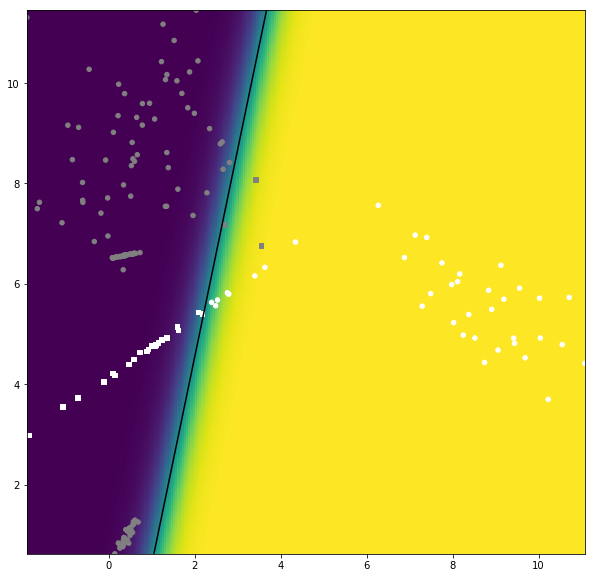

In [68]:
# inicijaliziraj generatore slučajnih brojeva
np.random.seed(2612)
tf.set_random_seed(100)

verbose = False
dim = 2
K = 6
C = 2
N = 30
param_delta = 0.5
param_niter = 1000

# instanciraj podatke X i labele Yoh_
X, Y_ = data.sample_gmm(K, C, N)
Yoh_ = data.class_to_onehot(Y_)

# izgradi graf:
tflr = TFLogreg(dim, C, param_delta)

# nauči parametre:
tflr.train(X, Yoh_, param_niter, verbose=verbose)

# dohvati vjerojatnosti na skupu za učenje
probs = tflr.eval(X)
Y = probs[:,1] > 0.5

# ispiši performansu (preciznost i odziv po razredima)


# iscrtaj rezultate, decizijsku plohu
def func(X):
    return tflr.eval(X)[:,1]

visualize_results(X, Y_, Y, func)